In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py


%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *


sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

from chainconsumer import ChainConsumer
%config InlineBackend.figure_format = 'retina'

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [16]:
update_TF, _ = get_TFcube_pars()

update_TF['g1'] = 0.05
update_TF['sini'] = 0.8
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.1185  # 0.032 

update_TF['redshift'] = 0.4
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.033 # 0.025
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)

#data = load_pickle("/Users/hhg/Research/kinematic_lensing/data/data.pickle")
#noise = load_pickle("/Users/hhg/Research/kinematic_lensing/data/noise.pickle")
#obslambda = np.load("/Users/hhg/Research/kinematic_lensing/data/obslambda.npy")


returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
CPU times: user 7.65 s, sys: 73 ms, total: 7.72 s
Wall time: 6.39 s


In [17]:
# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    data_info['data_list'] = data['spectra']
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']  = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image'] = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']   = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]


TF_pars

{'g1': 0.05,
 'g2': 0.0,
 'sini': 0.8,
 'diskFrac': 1.0,
 'n_knots': 25.0,
 'knot_fraction': 0.0,
 'aspect': 0.2,
 'vcirc': 200.0,
 'sigma_intr': 0.01,
 'redshift': 0.4,
 'half_light_radius': 0.5,
 'vscale': 0.5,
 'r_0': 0.0,
 'V_0': 0.0,
 'linelist': array([('OIIa', 372.7092, 2.e-25), ('OIIb', 372.9875, 2.e-25),
        ('OIIIa', 496.0295, 2.e-25), ('OIIIb', 500.824 , 2.e-25),
        ('Halpha', 656.461 , 6.e-24)],
       dtype=[('species', '<U16'), ('lambda', '<f8'), ('flux', '<f8')]),
 'norm': 0.0,
 'abs_magnitude': None,
 'image_size': 128,
 'ngrid': 256,
 'psfFWHM': 0.5,
 'psf_g1': 0.0,
 'psf_g2': 0.0,
 'area': 785000.0,
 'pixScale': 0.1185,
 'Resolution': 6000.0,
 'lambda_min': array([917.0454]),
 'lambda_max': array([921.0454]),
 'nm_per_pixel': 0.033,
 'gain': 1.0,
 'read_noise': 3.0,
 'throughput': 0.29,
 'expTime': 3600.0,
 'type_of_observation': 'slit',
 'fiber_size': 1.0,
 'fiber_offsets': [[0.0, 0.0],
  [1.0, 0.0],
  [-1.0, 0.0],
  [0.0, 1.0],
  [1.0, 1.0]],
 'slitAngles':

In [18]:
# compute theoretical e_obs

def calc_eint(sin_angle, q_z=0.2):
    return (1-q_z**2)*(sin_angle)**2/(2-(1-q_z**2)*sin_angle**2)

def cal_eobs(eint, gamma1):
    return  eint + 2*(1-eint**2)*gamma1

eint_thy = calc_eint(sin_angle=TF_pars['sini'])
eobs_thy = cal_eobs(eint=eint_thy, gamma1=TF_pars['g1'])
bestfit_e_obs = eobs_thy
bestfit_e_obs

0.5237560603555409

In [19]:
def cal_g1_bias_err(sigma_TF_intr):
    RotFit = RotationCurveFit(data_info, active_par_key = ['vscale','vcirc','cosi'], e_obs=bestfit_e_obs, sigma_TF_intr=sigma_TF_intr)
    chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)
    
    Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

    select_par_key = ['g1','vcirc','vscale','sini','e_int','vsini']
    parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

    g1_bestfit, g1_err = Chain.par_bestfit(select_par_key=['g1'], statistics='max', mode=1)
    g1_bias = g1_bestfit[0]-TF_pars['g1']
    g1_err  = g1_err[0]
    
    return g1_bias, g1_err

In [20]:
#sigma_list = [0.5, 5., 10., 20., 30., 40., 50.]
sigma_list = [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14]



g1_bias_list = []
g1_err_list = []

for sigma in sigma_list:
    print('sigma now:', sigma)
    g1_bias, g1_err = cal_g1_bias_err(sigma_TF_intr=sigma)
    
    g1_bias_list = g1_bias_list + [g1_bias]
    g1_err_list = g1_err_list + [g1_err]
    
    print(g1_bias, g1_err)

  0%|          | 0/3000 [00:00<?, ?it/s]

sigma now: 0.02
time cost in gaussFit_spec2D: 0.15912675857543945 (secs)


100%|██████████| 3000/3000 [00:13<00:00, 220.67it/s]


Total MCMC time (mins): 0.22669286330540975
-0.002252747603303587 0.08653332461642271
sigma now: 0.04
time cost in gaussFit_spec2D: 0.15007901191711426 (secs)


100%|██████████| 3000/3000 [00:12<00:00, 233.12it/s]


Total MCMC time (mins): 0.2145995338757833
0.011685533928471867 0.14553431024499652
sigma now: 0.06
time cost in gaussFit_spec2D: 0.14820289611816406 (secs)


100%|██████████| 3000/3000 [00:12<00:00, 241.91it/s]


Total MCMC time (mins): 0.20682116746902465
0.023352648412329244 0.22086655931728627
sigma now: 0.08
time cost in gaussFit_spec2D: 0.1477341651916504 (secs)


100%|██████████| 3000/3000 [00:12<00:00, 236.60it/s]


Total MCMC time (mins): 0.211438516775767
0.04483692622779638 0.2558991892037139
sigma now: 0.1
time cost in gaussFit_spec2D: 0.14730000495910645 (secs)


100%|██████████| 3000/3000 [00:12<00:00, 245.16it/s]


Total MCMC time (mins): 0.2040576696395874
0.049273366310289154 0.2618194522258611
sigma now: 0.12
time cost in gaussFit_spec2D: 0.14730405807495117 (secs)


100%|██████████| 3000/3000 [00:12<00:00, 239.84it/s]


Total MCMC time (mins): 0.20858356555302937
0.0579256964854578 0.29913302657095153
sigma now: 0.14
time cost in gaussFit_spec2D: 0.1460742950439453 (secs)


100%|██████████| 3000/3000 [00:13<00:00, 229.16it/s]

Total MCMC time (mins): 0.2182999849319458
0.07120965608927902 0.27713213243284607


In [21]:
g1_bias_list_08 = g1_bias_list
g1_err_list_08 = g1_err_list

In [15]:
g1_bias_list_01 = g1_bias_list
g1_err_list_01 = g1_err_list

In [7]:
g1_bias_list_05 = g1_bias_list
g1_err_list_05 = g1_err_list

[0.08653332461642271, 0.14553431024499652, 0.22086655931728627, 0.2558991892037139, 0.2618194522258611, 0.29913302657095153, 0.27713213243284607]
[0.023527078442727778, 0.04594407817825401, 0.05325314216247196, 0.057560520690438266, 0.06423463688931133, 0.07424622456399224, 0.0754784319558483]
[0.024517414751926397, 0.02516485751974306, 0.028607971955026287, 0.03134276906722288, 0.03222023271441052, 0.032219451719651536, 0.033624098209011424]


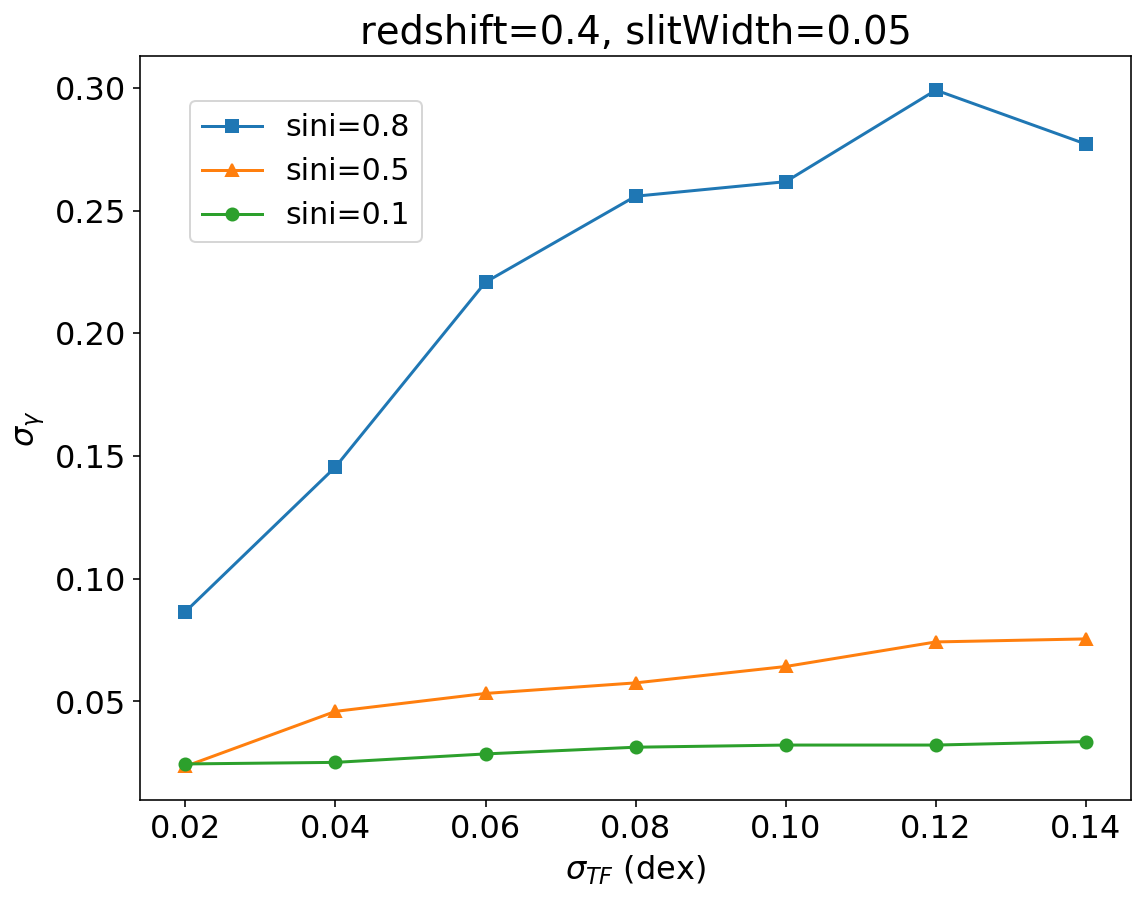

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8.,6.3))
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.11, top=0.93)
plt.rc('font',size=16)

ax.plot(sigma_list, g1_err_list_08, 's', linestyle='-', label="sini=0.8")
ax.plot(sigma_list, g1_err_list_05, '^', linestyle='-', label="sini=0.5")
ax.plot(sigma_list, g1_err_list_01, 'o', linestyle='-', label="sini=0.1")

print(g1_err_list_08)
print(g1_err_list_05)
print(g1_err_list_01)

ax.legend(loc=(0.05,0.75),prop={'size':15})

ax.set_title('redshift=%.1f, slitWidth=%.2f'%(TF_pars['redshift'],TF_pars['slitWidth']))
ax.set_ylabel('$\sigma_{\gamma}$')
ax.set_xlabel('$\sigma_{TF}$ (dex)')

fig.savefig('/Users/hhg/Desktop/sigma_gamma.pdf')

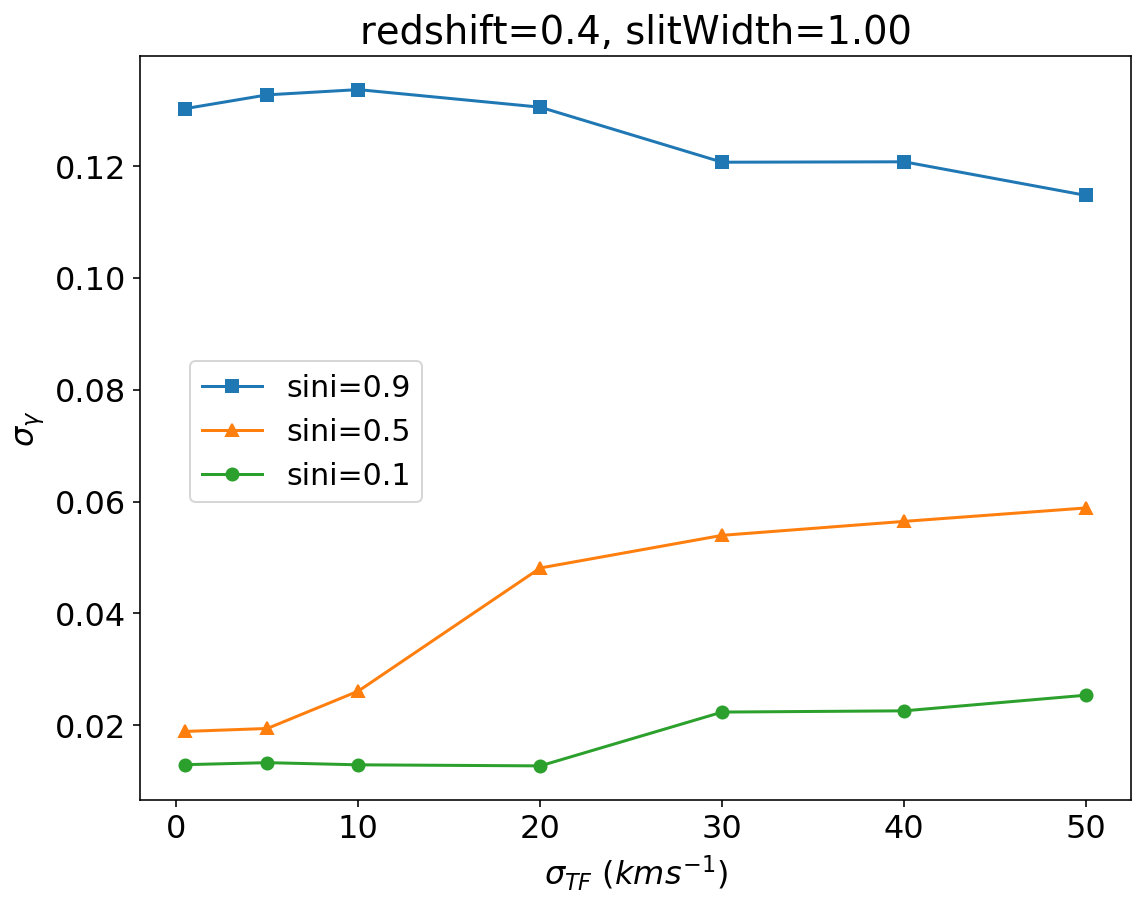

In [47]:
fig, ax = plt.subplots(1,1, figsize=(8.,6.3))
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.11, top=0.93)
plt.rc('font',size=16)

ax.plot(sigma_list, g1_err_list_09, 's', linestyle='-', label="sini=0.9")
ax.plot(sigma_list, g1_err_list_05, '^', linestyle='-', label="sini=0.5")
ax.plot(sigma_list, g1_err_list_01, 'o', linestyle='-', label="sini=0.1")


ax.legend(loc=(0.05,0.4),prop={'size':15})

ax.set_title('redshift=%.1f, slitWidth=%.2f'%(TF_pars['redshift'],TF_pars['slitWidth']))
ax.set_ylabel('$\sigma_{\gamma}$')
ax.set_xlabel('$\sigma_{TF}$ ($kms^{-1}$)')

fig.savefig('/Users/hhg/Desktop/sigma_gamma.pdf')

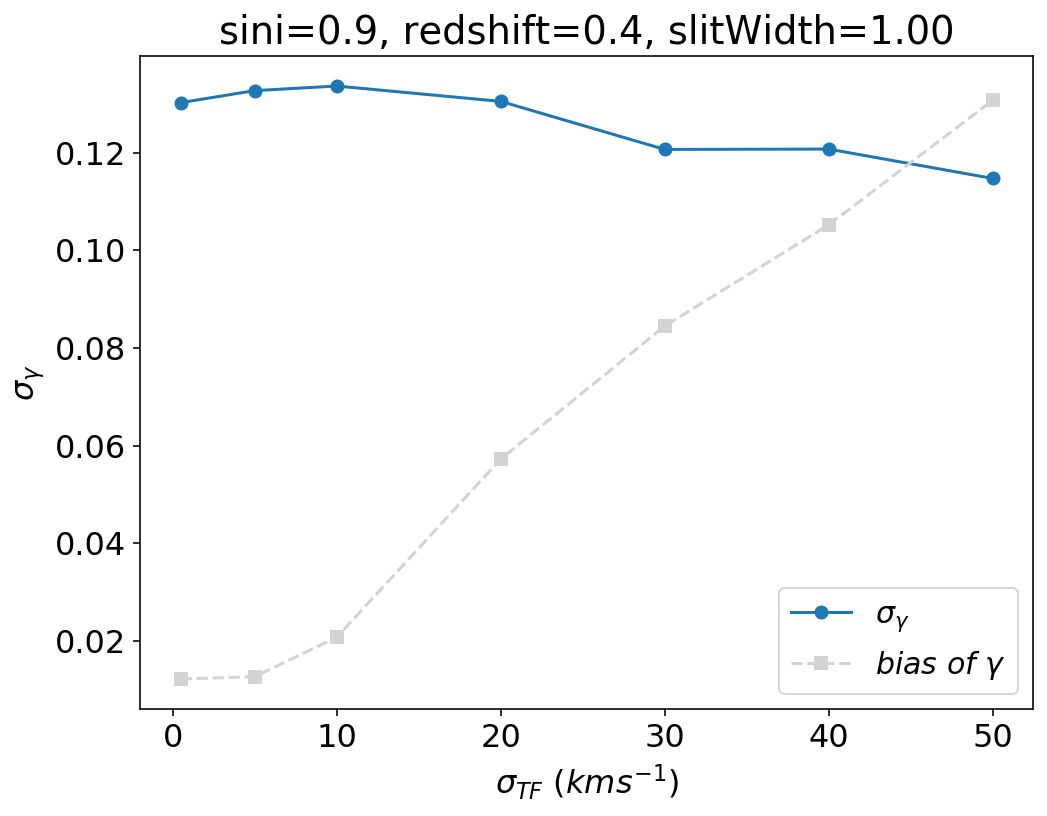

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8.,6.))
plt.rc('font',size=16)

ax.plot(sigma_list, g1_err_list, 'o', linestyle='-', label="$\sigma_{\gamma}$")
ax.plot(sigma_list, g1_bias_list, 's', linestyle='--', label="$bias\ of\ \gamma$",color='lightgray')


ax.legend(loc='best',prop={'size':15})

ax.set_title('sini=%.1f, redshift=%.1f, slitWidth=%.2f'%(TF_pars['sini'],TF_pars['redshift'],TF_pars['slitWidth']))
ax.set_ylabel('$\sigma_{\gamma}$')
ax.set_xlabel('$\sigma_{TF}$ ($kms^{-1}$)')

fig.savefig('/Users/hhg/Desktop/sigma_gamma.pdf')

# End

### Fit 2D spectrum (code bit for debug)

In [8]:
# init Fit tool

sigma_TF_intr = 20.

RotFit = RotationCurveFit(data_info, active_par_key = ['vscale','vcirc','sini'], e_obs=bestfit_e_obs, sigma_TF_intr=sigma_TF_intr)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)


/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 24/3000 [00:00<00:12, 233.08it/s]

time cost in gaussFit_spec2D: 0.14207887649536133 (secs)


100%|██████████| 3000/3000 [00:11<00:00, 263.82it/s]

Total MCMC time (mins): 0.18966838518778484


In [9]:
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

select_par_key = ['g1','vcirc','vscale','sini','e_int','vsini']
parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

g1_bestfit, g1_err = Chain.par_bestfit(select_par_key=['g1'], statistics='max', mode=1)
g1_bias = g1_bestfit[0]-TF_pars['g1']
g1_err  = g1_err[0]

print("g1_bias:",g1_bias)
print("g1_err:",g1_err)

g1_bias: 0.06070841307388801
g1_err: 0.1313713169714142
